In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

# pyomo
import importlib
import neural_net_pyomo

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

collocation_path = os.path.abspath(os.path.join('..', 'utils'))

if collocation_path not in sys.path:
    sys.path.append(collocation_path)
    
from interpolation import BarycentricInterpolation

### Data Generation

In [13]:
data = pd.read_csv('df_train.csv')

data = data[data.settlement_date >= '2010-01-01']
data = data[data.settlement_date < '2011-01-01']
data.reset_index(drop=True, inplace=True)

data.loc[:,'hour'] = pd.to_datetime(data['settlement_date']).dt.hour

# select the main columns for the intial testing
data_subsample = data[['temperature', 'hour', 'nd']][:400]

t = jnp.linspace(0., 1., data_subsample.shape[0])

def generate_chebyshev_nodes(n, start, end):
    k = np.arange(n)
    x = np.cos(np.pi * k / (n - 1))
    nodes = 0.5 * (end - start) * x + 0.5 * (start + end)
    return np.sort(nodes)

# interpolate the whole dataset
cs_temp = CubicSpline(t, data_subsample['temperature'])
cs_hour = CubicSpline(t, data_subsample['hour'])
cs_nd = CubicSpline(t, data_subsample['nd'])

#-------------------------------------TRAIN-TEST SPLIT-------------------------------------#
split, end = 200, 400

t_train = t[:split]
t_test = t[split:end]

#-------------------------------------CHEBYSHEV NODES--------------------------------------#
train_end = t_train.shape[0] # 3 times the number of training points
x_train_cheb = generate_chebyshev_nodes(train_end, 0, t_test.min())

y_train_temp = cs_temp(x_train_cheb)
y_train_hour = cs_hour(x_train_cheb)
y_train_nd = cs_nd(x_train_cheb)

#----------------------------------COMBINE INTO TRAIN--------------------------------------#
X_train = np.vstack([y_train_temp, y_train_hour]).T
# X_train = y_train_temp.T
X_train = pd.DataFrame(X_train, columns=['temperature', 'hour'])
y_train = pd.DataFrame(y_train_nd)

data_test = data_subsample[split:end]

#----------------------------------LOCATE TEST SET---------------------------------------#
X_test = data_test[['temperature', 'hour']]
y_test = data_test['nd']

#---------------------------------------SCALE--------------------------------------------#
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [16]:
data[:200]

settlement_date  temperature  precip  cloudcover  humidity  \
0    2010-01-01 00:00:00         2.50     0.0       43.60    75.520   
1    2010-01-01 00:30:00         1.55     0.0       39.85    80.855   
2    2010-01-01 01:00:00         0.60     0.0       36.10    86.190   
3    2010-01-01 01:30:00         0.70     0.0       42.45    85.665   
4    2010-01-01 02:00:00         0.80     0.0       48.80    85.140   
..                   ...          ...     ...         ...       ...   
195  2010-01-05 01:30:00        -5.25     0.0       55.00    95.165   
196  2010-01-05 02:00:00        -5.30     0.0       30.00    94.960   
197  2010-01-05 02:30:00        -5.35     0.0       20.00    94.850   
198  2010-01-05 03:00:00        -5.40     0.0       10.00    94.740   
199  2010-01-05 03:30:00        -5.35     0.0       35.00    94.450   

     windspeed        conditions       nd  pump_storage_pumping  is_holiday  \
0        16.20  Partially cloudy  36453.0                 306.0         1.0   
1        15.10  Partially cloudy  36680.0                 223.0         1.0   
2        14.00  Partially cloudy  36343.0                 288.0         1.0   
3        15.35  Partially cloudy  35362.0                 291.0         1.0   
4        16.70  Partially cloudy  34366.0                 361.0         1.0   
..         ...               ...      ...                   ...         ...   
195       5.70  Partially cloudy  37057.0                1555.0         0.0   
196       4.60  Partially cloudy  36748.0                1545.0         0.0   
197       4.00  Partially cloudy  36969.0                1525.0         0.0   
198       3.40             Clear  36757.0                1598.0         0.0   
199       4.15             Clear  36005.0                1595.0         0.0   

     hour  
0       0  
1       0  
2       1  
3       1  
4       2  
..    ...  
195     1  
196     2  
197     2  
198     3  
199     3  

[200 rows x 11 columns]

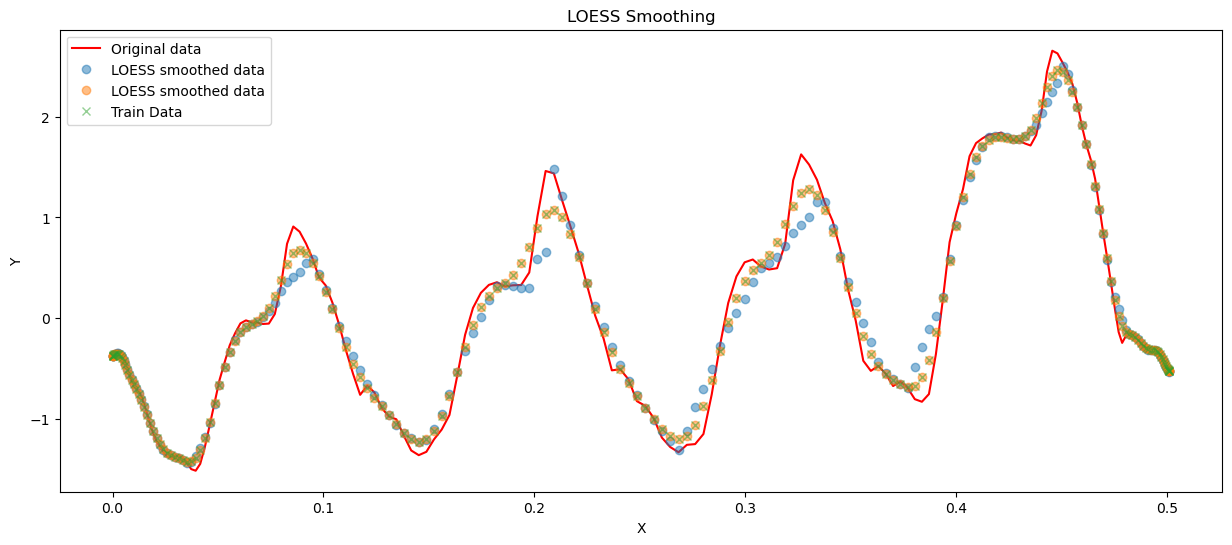

In [14]:
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

lowess = sm.nonparametric.lowess
y_smoothed = lowess(np.squeeze(y_train_scaled), x_train_cheb, frac=0.05)  # `frac` is the fraction of data used for each local model
y_new = y_smoothed[:, 1]
x_new = y_smoothed[:, 0]

y_new_gaussian = gaussian_filter1d(np.squeeze(y_train_scaled), sigma=2)
cs_y_new = CubicSpline(x_new, y_new_gaussian)
y_train_cheb = cs_y_new(x_train_cheb)

plt.figure(figsize=(15, 6))
plt.plot(x_train_cheb, y_train_scaled, 'r-', label='Original data')
plt.plot(x_new, y_new, 'o', label='LOESS smoothed data', alpha=0.5)
plt.plot(x_new, y_new_gaussian, 'o', label='LOESS smoothed data', alpha=0.5)
plt.plot(x_train_cheb, y_train_cheb, 'x', label='Train Data', alpha=0.5)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LOESS Smoothing')
plt.show()


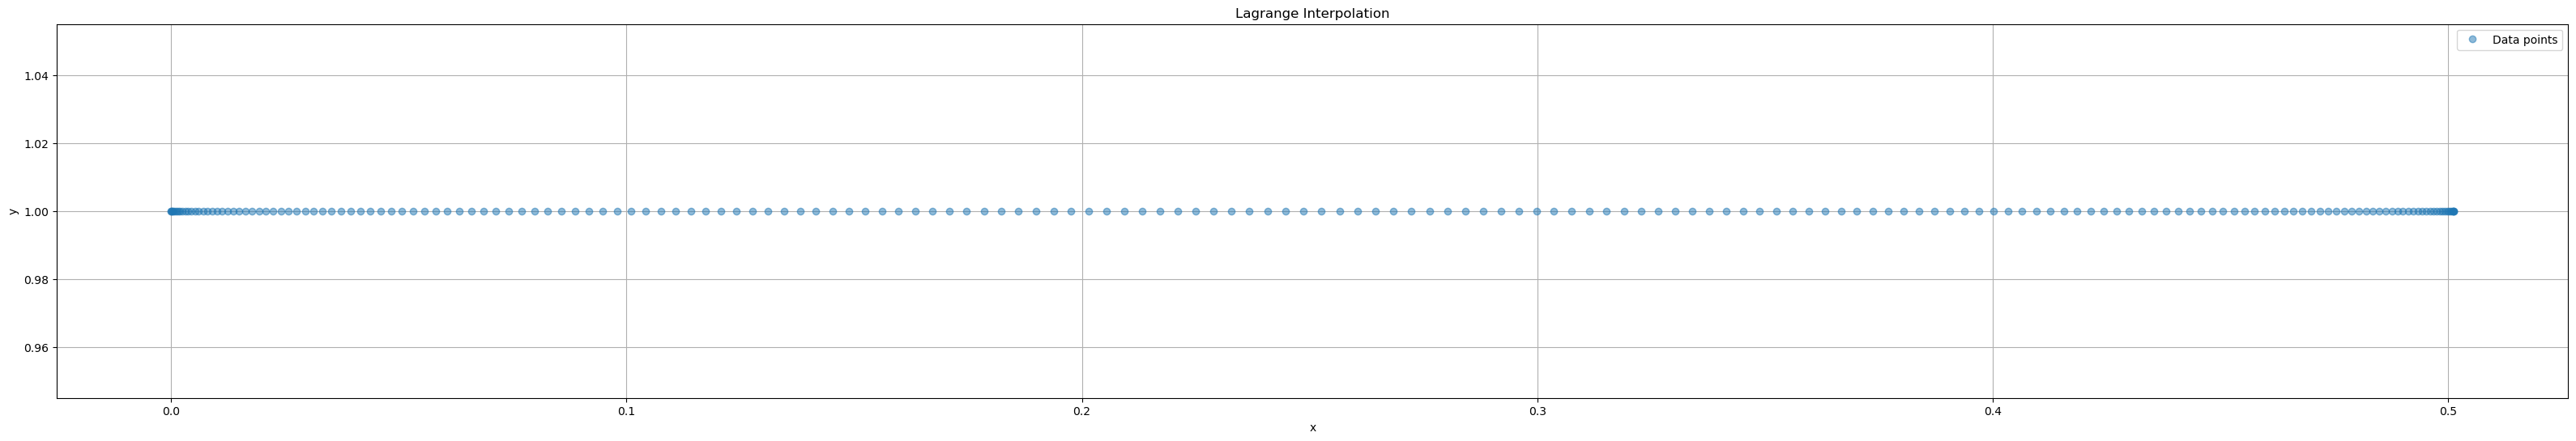

In [5]:
ones = np.ones_like(x_train_cheb)

plt.figure(figsize=(40, 6))
plt.plot(x_train_cheb, ones, 'o', label='Data points', alpha = 0.5)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lagrange Interpolation')
plt.grid(True)
plt.show()

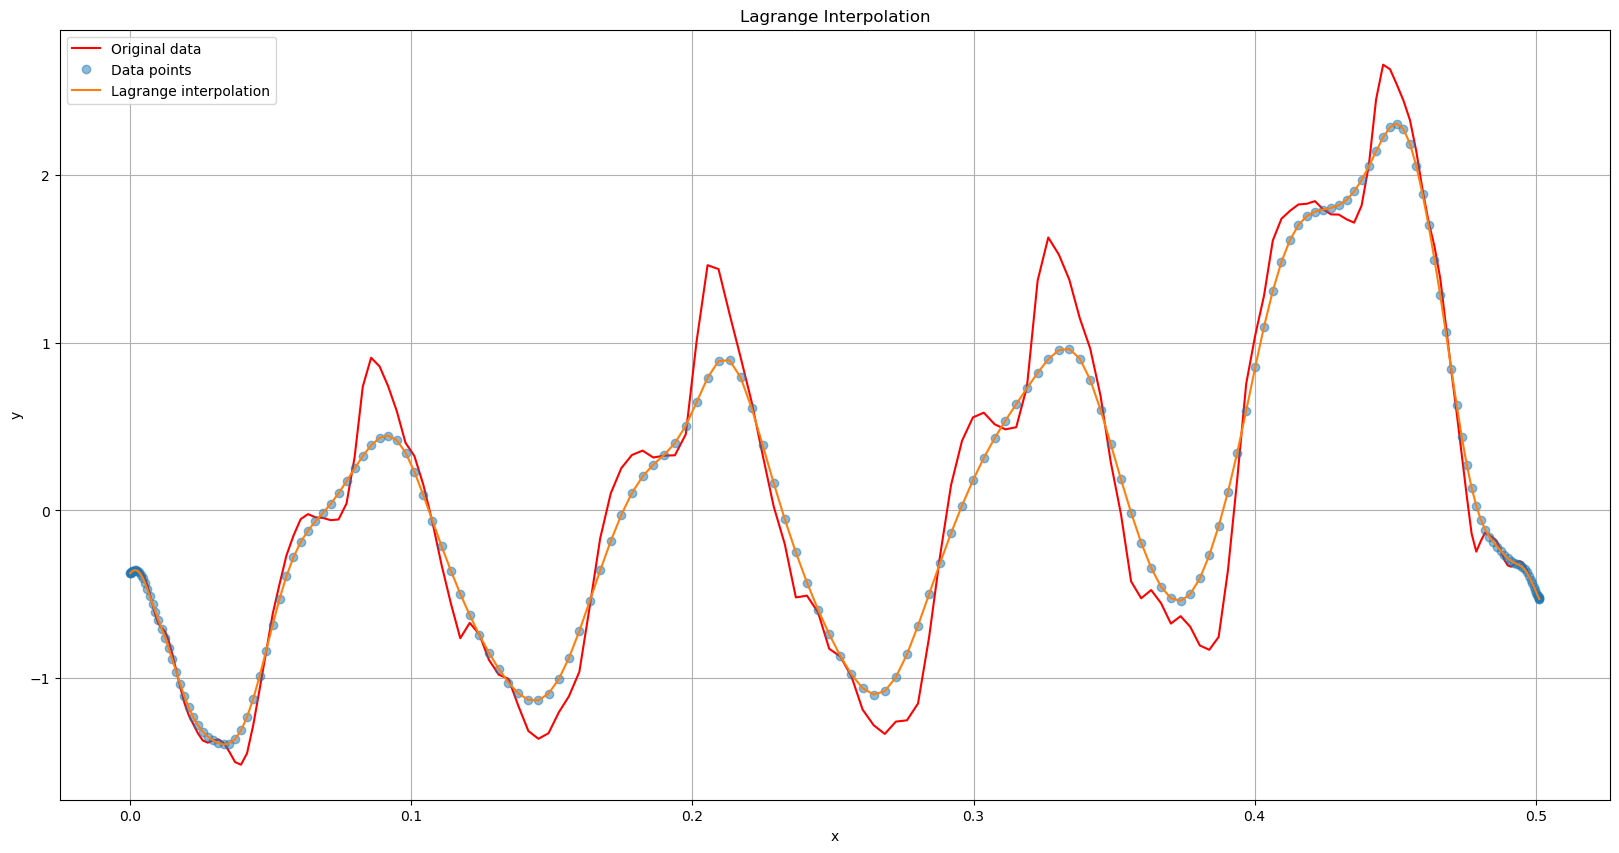

In [54]:
interpolator1 = BarycentricInterpolation(len(x_train_cheb), np.min(x_train_cheb), np.max(x_train_cheb))
# collocation_nodes = interpolator1.nodes

interpolator1.fit(y_train_cheb)
y_interpolated = interpolator1.evaluate(x_train_cheb)

plt.figure(figsize=(20, 10))
plt.plot(x_train_cheb, y_train_scaled, 'r-', label='Original data')
plt.plot(x_train_cheb, y_train_cheb, 'o', label='Data points', alpha = 0.5)
plt.plot(x_train_cheb[:], y_interpolated[:],label='Lagrange interpolation')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lagrange Interpolation')
plt.grid(True)
plt.show()

### Data Check

In [55]:
weights = compute_weights(x_train_cheb)
D = np.array(lagrange_derivative(x_train_cheb, weights))

`initial model version`

In [56]:
y = y_train_cheb
ys = np.array(y)
ys = np.atleast_2d(ys).T
ts = np.array(x_train_cheb)
Ds = np.array(D)
extra_input = np.array(X_train_scaled)

(200, 1)


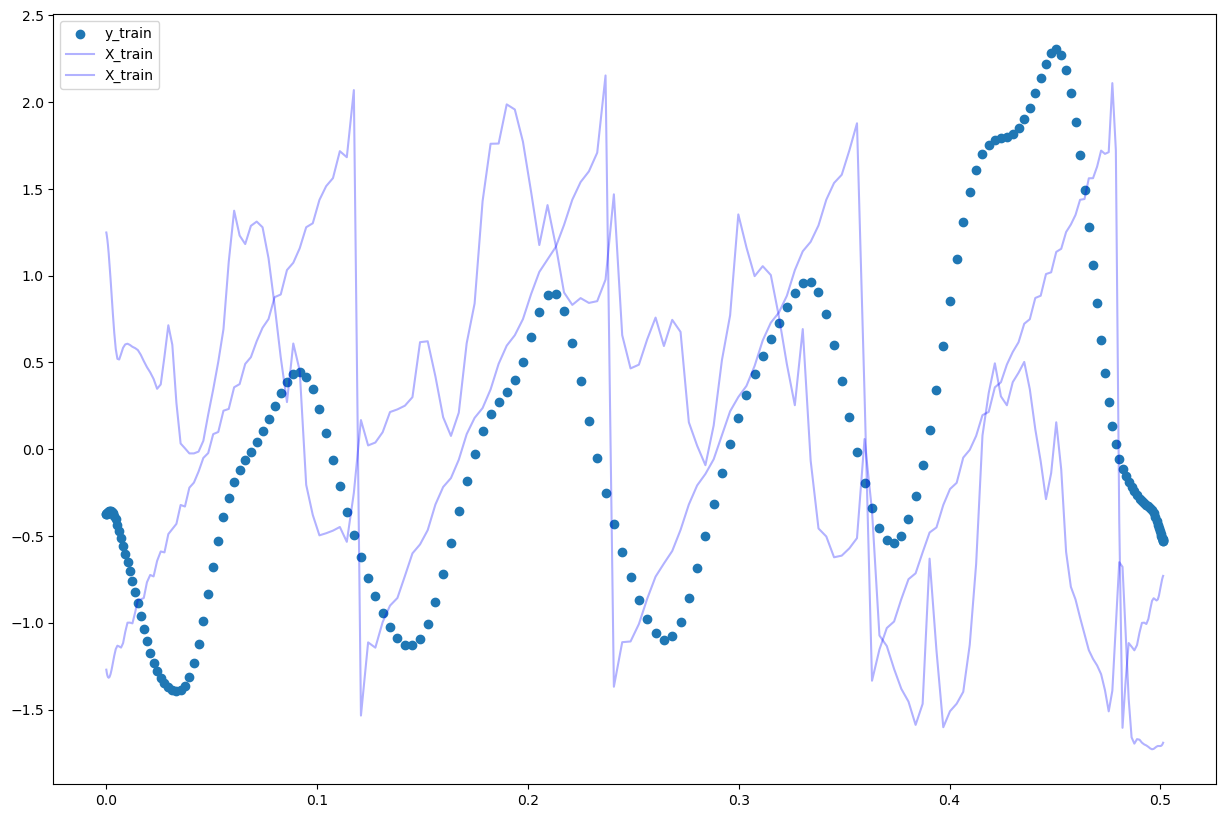

In [57]:
print(ys.shape)
plt.figure(figsize=(15, 10))
#plt.plot(t, data_subsample['temperature'], color='red', label='Original Data')
#plt.scatter(ts, estimated_solution, label='y_train')
plt.scatter(ts, ys, label='y_train')
plt.plot(ts, extra_input, 'b-', label='X_train', alpha = 0.3)

#plt.plot(t_test, X_test_scaled, label='X_test', alpha = 0.5)
#plt.plot(t_test, y_test_scaled, label='y_test', ls = '--')

plt.legend()
plt.show()

In [58]:
import neural_net_pyomo_2

importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

# ----------------------------------------------------------- #
#import neural_net_pyomo

#importlib.reload(neural_net_pyomo)
#NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo
# ----------------------------------------------------------- #

layer_widths = [3, 20, 1]

# solver.options['print_level'] = 5
tol = 1e-7
params = {"tol":1e-7, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          # "acceptable_tol": 1e-15,
          # "acceptable_constr_viol_tol": 1e-15,
          # "acceptable_dual_inf_tol": 1e-15,
          # "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 2, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 1000}

ode_model = NeuralODEPyomo(np.array(ys), # y
                           np.array(ts), # t
                           np.array(Ds),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = ys, 
                           penalty_lambda_reg = 0.00001, 
                           penalty_lambda_input = 0.0,
                           # constraint_penalty = 1e-5,  
                           time_invariant=True,
                           extra_input = extra_input, # X
                           w_init_method = 'random', 
                           params = params
                           # constraint="l1"
                           )

ode_model.build_model()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



{'solver_time': 3.8063740730285645, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


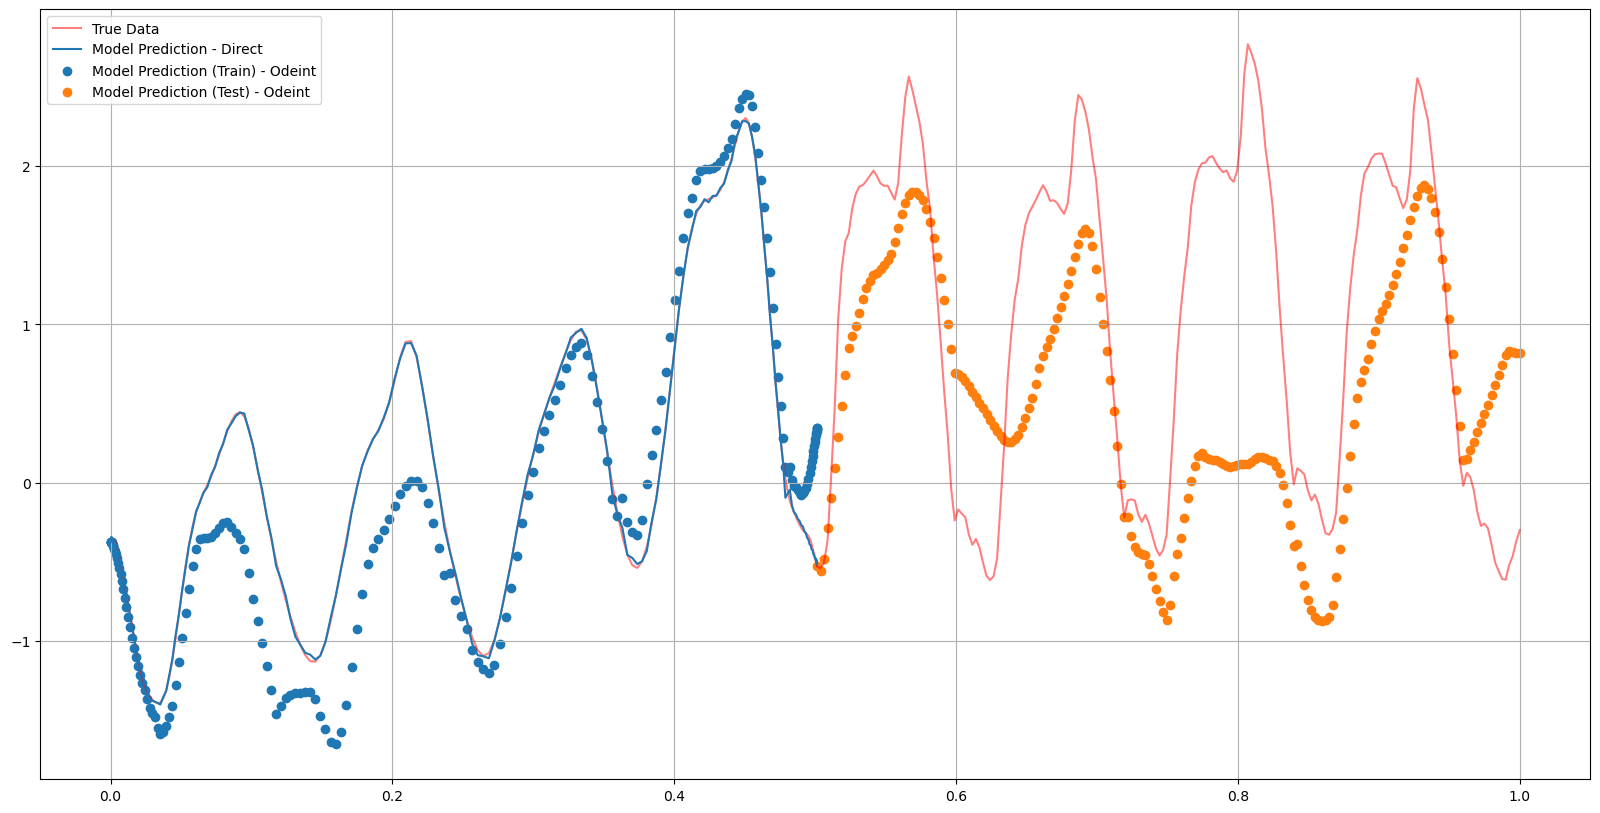

In [59]:
y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (extra_input, ts))
y1 = y_pred[-1]

# test
y_init_test = ys[-1]
extra_args = np.array(X_test_scaled)
y_pred_test = ode_model.neural_ode(y_init_test, t_test, (extra_args, t_test))

plt.figure(figsize=(20, 10))
#plt.plot(ts, y_train_scaled[offset : train_end], label='True Data', alpha = 0.5)
plt.plot(ts, ys, 'r', label='True Data', alpha = 0.5)
plt.plot(t_test, y_test_scaled, 'r', alpha = 0.5)
#plt.plot(ts, extra_input, label='X_train', alpha = 0.3, ls = '--')
#plt.plot(t_test, np.array(X_test_scaled), alpha = 0.3, ls = '--')

plt.plot(ts, u_model, label='Model Prediction - Direct')
plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')
plt.scatter(t_test, y_pred_test, label='Model Prediction (Test) - Odeint')
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

### Build Model x10 times

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 3.830937147140503, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


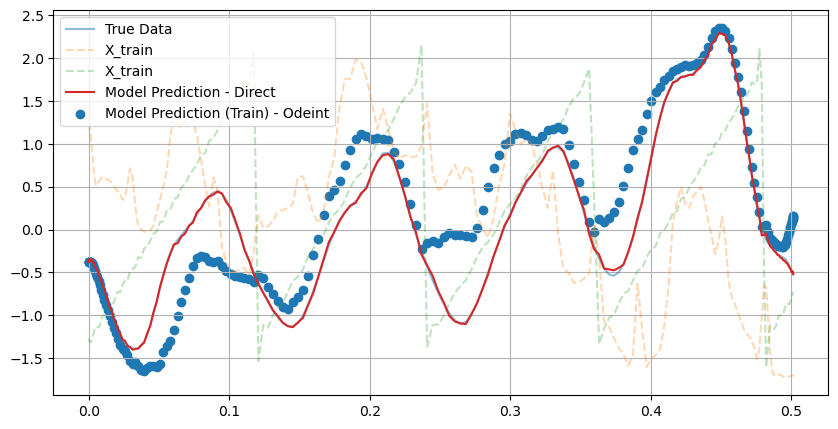

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 4.008872032165527, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


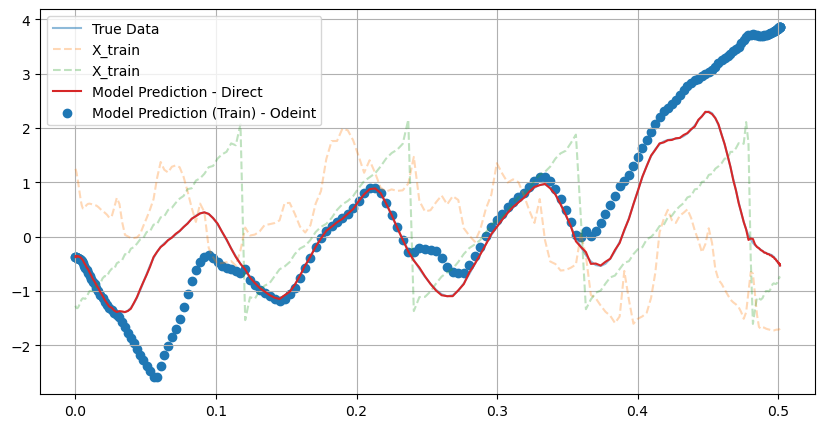

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 4.1379640102386475, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


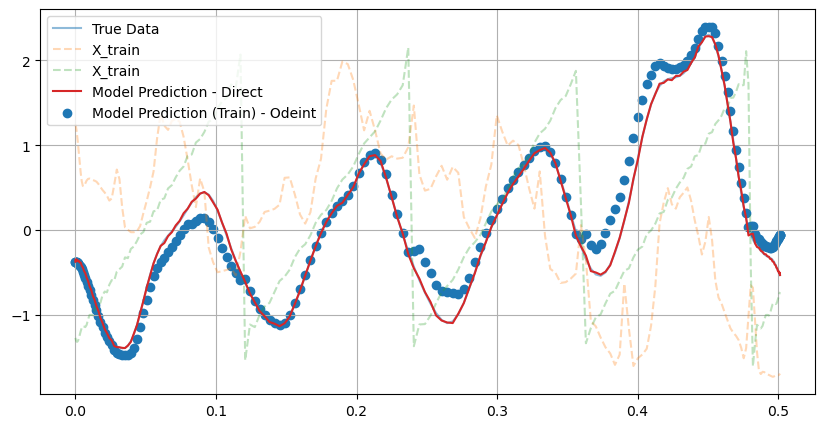

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 5.406277894973755, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


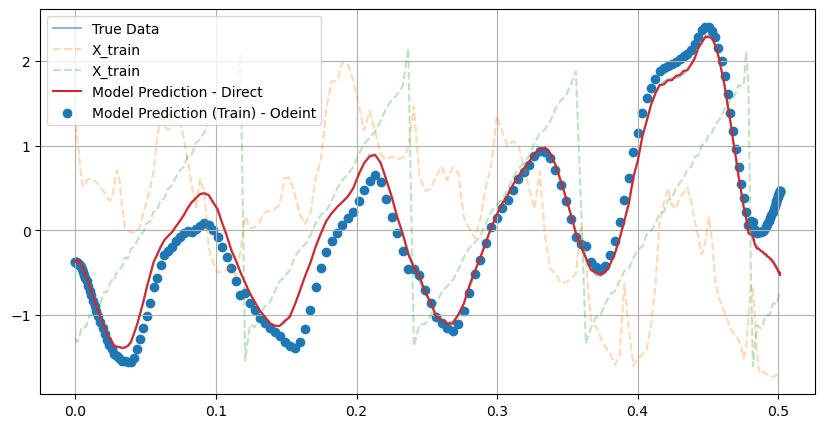

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 4.548431873321533, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


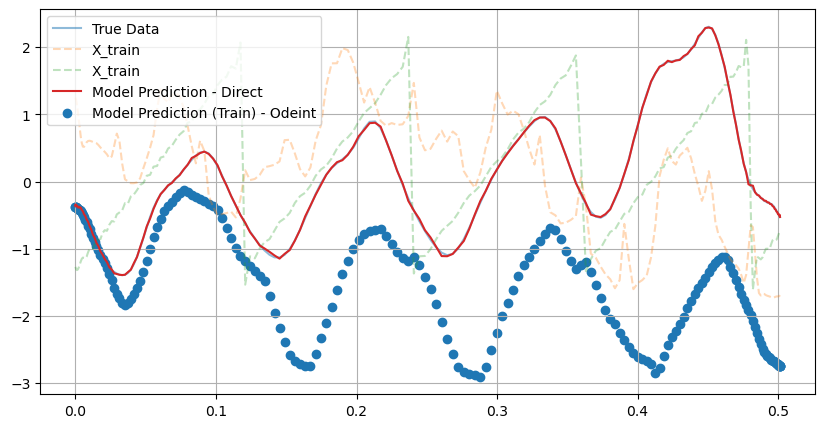

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 3.376436948776245, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


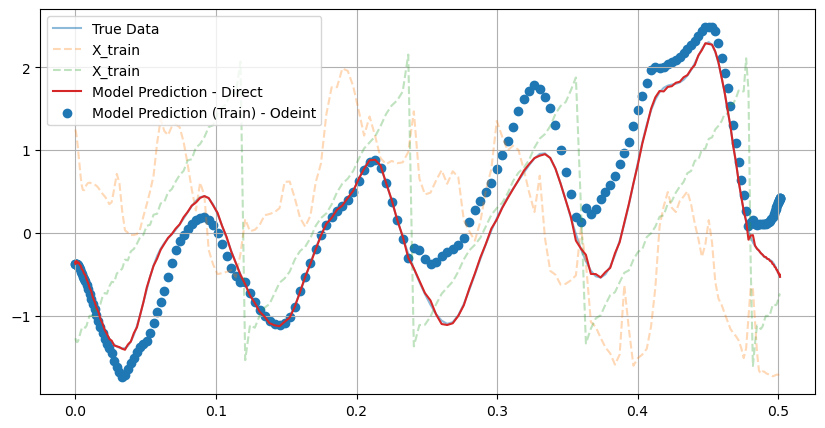

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 4.270085096359253, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


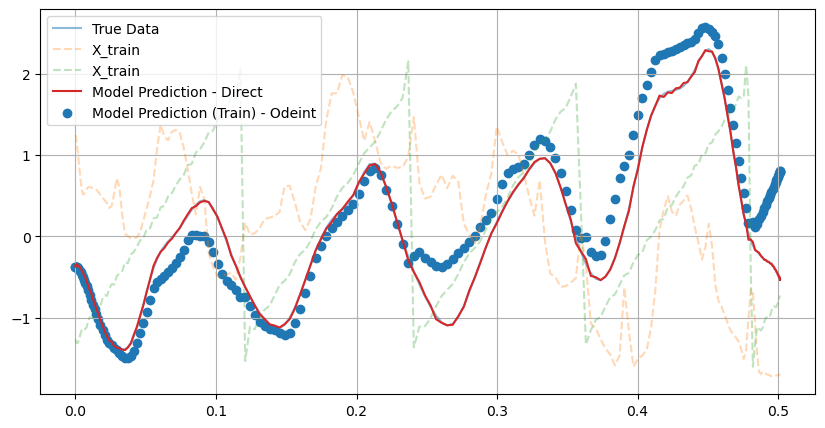

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 3.313621759414673, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


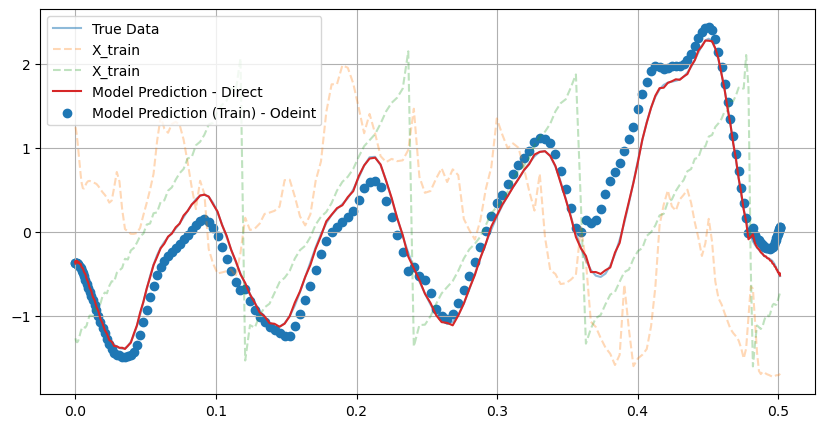

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.829523801803589, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


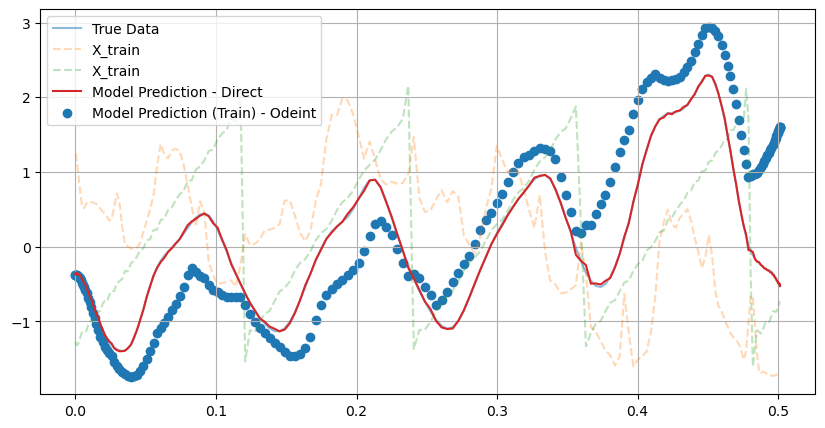

In [60]:
for i in range(1, 10):
    ode_model = NeuralODEPyomo(np.array(ys), # y
                           np.array(ts), # t
                           np.array(Ds),
                           layer_widths, act_func = "tanh", 
                           y_init = ys, 
                           penalty_lambda_reg = 0.00001, 
                           penalty_lambda_input = 0.0,
                           time_invariant=True,
                           extra_input = extra_input, # X
                           w_init_method = 'random', 
                           params = params
                           )
    
    ode_model.build_model()

    result = ode_model.solve_model()
    u_model = ode_model.extract_solution().T
    y0 = ys[0]
    y_pred = ode_model.neural_ode(y0, ts, (extra_input, ts))
    y1 = y_pred[-1]

    # test
    y_init_test = y_pred[-1]
    extra_args = np.array(X_test_scaled)

    plt.figure(figsize=(10, 5))
    plt.plot(ts, ys, label='True Data', alpha = 0.5)
    plt.plot(ts, extra_input, label='X_train', alpha = 0.3, ls = '--')

    plt.plot(ts, u_model, label='Model Prediction - Direct')
    plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')
    plt.legend(loc ="upper left")
    plt.grid(True)
    plt.show()

---

### Train Data; adding lagged values

(200, 4)


/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_47778/2620787424.py:34: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_train_cheb_lags, Xs, 'b-', label='Dependent Variables', alpha=0.4, ls = '--')


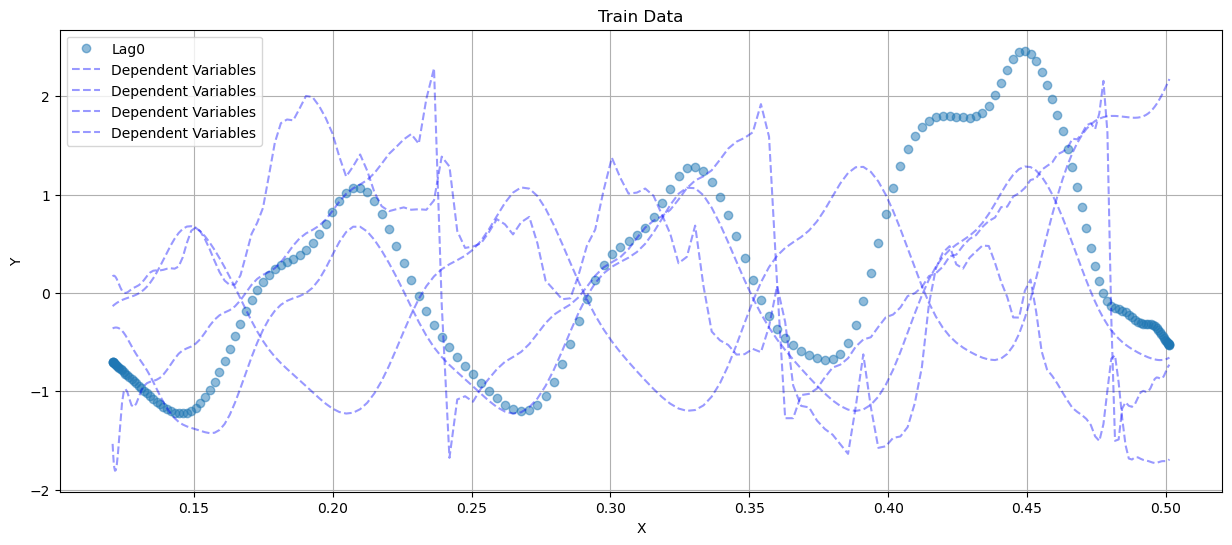

In [17]:
x_train_cheb_lag1 = x_train_cheb + 0.06
x_train_cheb_lag2 = x_train_cheb + 0.12

map = x_train_cheb < x_train_cheb_lag2[0]
OFFSET = len(x_train_cheb_lag1[map])

x_new = x_train_cheb[OFFSET:]
x_train_cheb_lags = generate_chebyshev_nodes(train_end, x_new.min(), x_new.max())

cs_lag0 = CubicSpline(x_train_cheb, y_train_cheb)
y_train_cheb_lag0 = cs_lag0(x_train_cheb_lags)

cs_lag1 = CubicSpline(x_train_cheb_lag1, y_train_cheb)
y_train_cheb_lag1 = cs_lag1(x_train_cheb_lags)

cs_lag2 = CubicSpline(x_train_cheb_lag2, y_train_cheb)
y_train_cheb_lag2 = cs_lag2(x_train_cheb_lags)

# TEMPERATURE
x_train_temp = np.array(X_train_scaled['temperature'])
cs_temp = CubicSpline(x_train_cheb, x_train_temp)
x_train_temp = cs_temp(x_train_cheb_lags)

# HOUR
x_train_hour = np.array(X_train_scaled['hour'])
cs_hour = CubicSpline(x_train_cheb, x_train_hour)
x_train_hour = cs_hour(x_train_cheb_lags)

Xs = np.vstack([y_train_cheb_lag1, y_train_cheb_lag2, x_train_hour, x_train_temp]).T

print(Xs.shape)
plt.figure(figsize=(15, 6))
plt.plot(x_train_cheb_lags, y_train_cheb_lag0, 'o', label='Lag0', alpha=0.5)
plt.plot(x_train_cheb_lags, Xs, 'b-', label='Dependent Variables', alpha=0.4, ls = '--')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Train Data')
plt.grid(True)
plt.show()

### Test Set

In [18]:
# t_train = np.linspace(0, np.max(t_train), train_end)

print(f'The current train set is from {np.min(x_train_cheb_lags):.3f} to {np.max(x_train_cheb_lags):.3f} with {len(x_train_cheb_lags)} points')
print(f'The current test set is from {np.min(t_test):.3f} to {np.max(t_test):.3f} with {len(t_test)} points')

# ADD MORE TEST POINTS
t_test_new = np.linspace(np.min(t_test), np.max(t_test), len(t_test)*3)
cs_test = CubicSpline(t_test, y_test_scaled)
y_test_scaled_new = cs_test(t_test_new)

cs_temp_test = CubicSpline(t_test, X_test_scaled['temperature'])
cs_hour_test = CubicSpline(t_test, X_test_scaled['hour'])

x_test_temp = cs_temp_test(t_test_new)
x_test_hour = cs_hour_test(t_test_new)

The current train set is from 0.121 to 0.501 with 200 points
The current test set is from 0.501 to 1.000 with 200 points


#### Generate time lags for the test set

In [19]:
# regenerate the full range for visual references
y = cs_nd(t)
y_scaled = scaler.transform(y.reshape(-1, 1))

# generate time points to use for the interpolation
# starting from the min t_test_new
# ending at the last time point of the lag1/2 available from the training set
# hence, the last interpolationg pt should be <= then the last time point of train lag
map_lag1 = (t_test_new <= x_train_cheb_lag1[-1])
map_lag2 = (t_test_new <= x_train_cheb_lag2[-1]) 

# interpolate
x_lag1_available = cs_lag1(t_test_new[map_lag1])
x_lag2_available = cs_lag2(t_test_new[map_lag2])

# after the last available point, the rest needs to be obtained from the model

# to start with, we can test the model with the available points
# let's form the training data
len(t_test_new[map_lag1])
# we only have 10 points available from the lag1

ts_test = t_test_new[map_lag1]
print(ts_test.shape)

(73,)


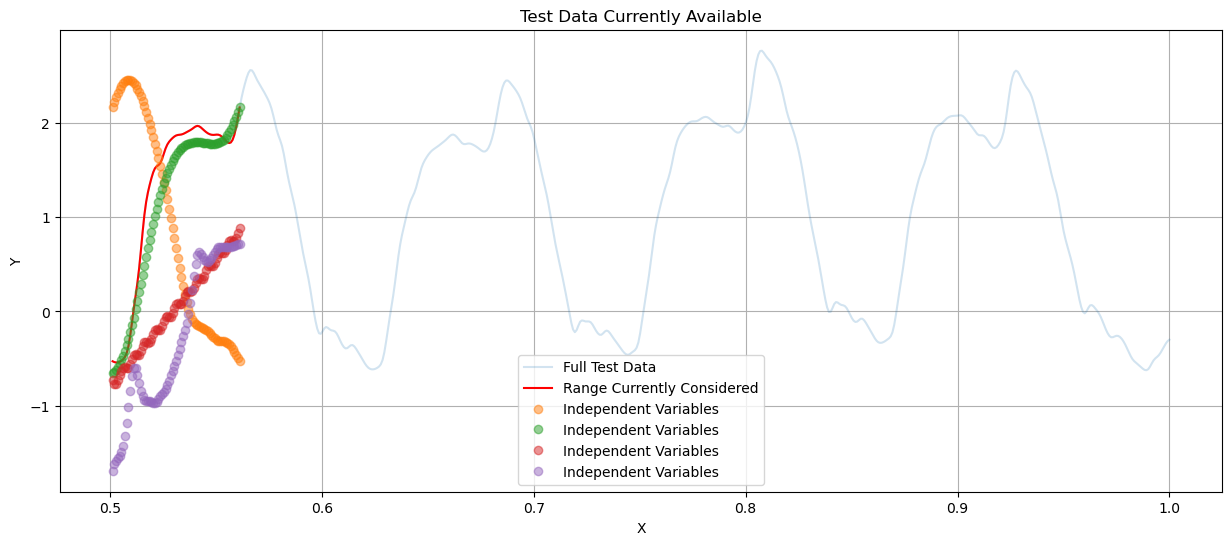

In [20]:
# lag1, lag2, hour, temperature
Xs_test = np.vstack([x_lag1_available, x_lag2_available[:len(ts_test)], x_test_hour[:len(ts_test)], x_test_temp[:len(ts_test)]]).T
ys_test = y_test_scaled_new[:len(ts_test)]

plt.figure(figsize=(15, 6))
plt.plot(t_test_new, y_test_scaled_new, label='Full Test Data', alpha = 0.2)
plt.plot(ts_test, ys_test, 'r-', label='Range Currently Considered')
plt.plot(ts_test, Xs_test, 'o', label='Independent Variables', alpha=0.5)
#plt.plot(ts_test, x_lag1_available, 'o', label='X_lag1')
#plt.plot(ts_test, x_lag2_available[:len(ts_test)], 'o', label='X_lag2')
#plt.plot(ts_test, x_test_temp[:len(ts_test)], 'o', label='temperature', alpha =0.3)
#plt.plot(ts_test, x_test_hour[:len(ts_test)], 'o', label='hour', alpha = 0.3)

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Test Data Currently Available')
plt.grid(True)
plt.show()

In [21]:
weights = compute_weights(x_train_cheb_lags)
D = np.array(lagrange_derivative(x_train_cheb_lags, weights))

ys = np.array(y_train_cheb_lag0)
ys = np.atleast_2d(ys).T

ts = np.array(x_train_cheb_lags)
Ds = np.array(D)

(200, 4)


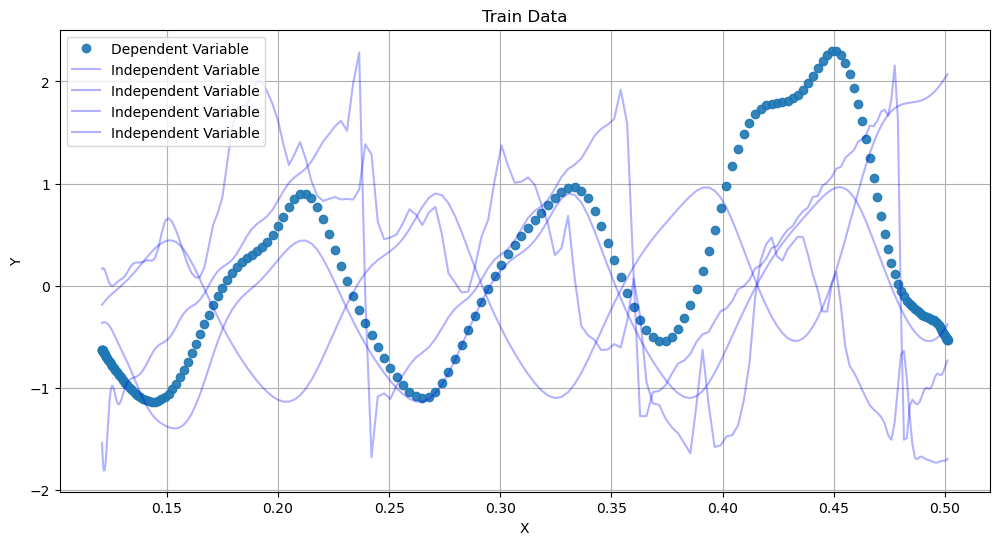

In [68]:
print(Xs.shape)
plt.figure(figsize=(12, 6))
plt.plot(ts, ys, 'o', label='Dependent Variable', alpha=0.9)
plt.plot(ts, Xs, 'b-', label='Independent Variable', alpha=0.3)
# plt.plot(x_train_cheb_lag2[first_pos_index], y_train_cheb[first_pos_index], 'o', label='First Positive Value of the Offset', alpha=0.7)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Train Data')
plt.grid(True)
plt.show()

In [73]:
importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

# ----------------------------------------------------------- #
#import neural_net_pyomo

#importlib.reload(neural_net_pyomo)
#NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo
# ----------------------------------------------------------- #

layer_widths = [5, 20, 1]

# solver.options['print_level'] = 5
tol = 1e-10
params = {"tol":1e-10, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          # "acceptable_tol": 1e-15,
          # "acceptable_constr_viol_tol": 1e-15,
          # "acceptable_dual_inf_tol": 1e-15,
          # "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 1000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(ys), # y
                           np.array(ts), # t
                           np.array(Ds),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = ys, 
                           penalty_lambda_reg = 0.001, 
                           penalty_lambda_input = 0.0000,
                           # constraint_penalty = 1e-5,  
                           time_invariant = True,
                           extra_input = Xs, # X
                           w_init_method = 'xavier', 
                           params = params
                           # constraint="l1"
                           )

ode_model.build_model()
end_timer_build = time.time()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    67859
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    28621

Total number of variables............................:      341
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      34

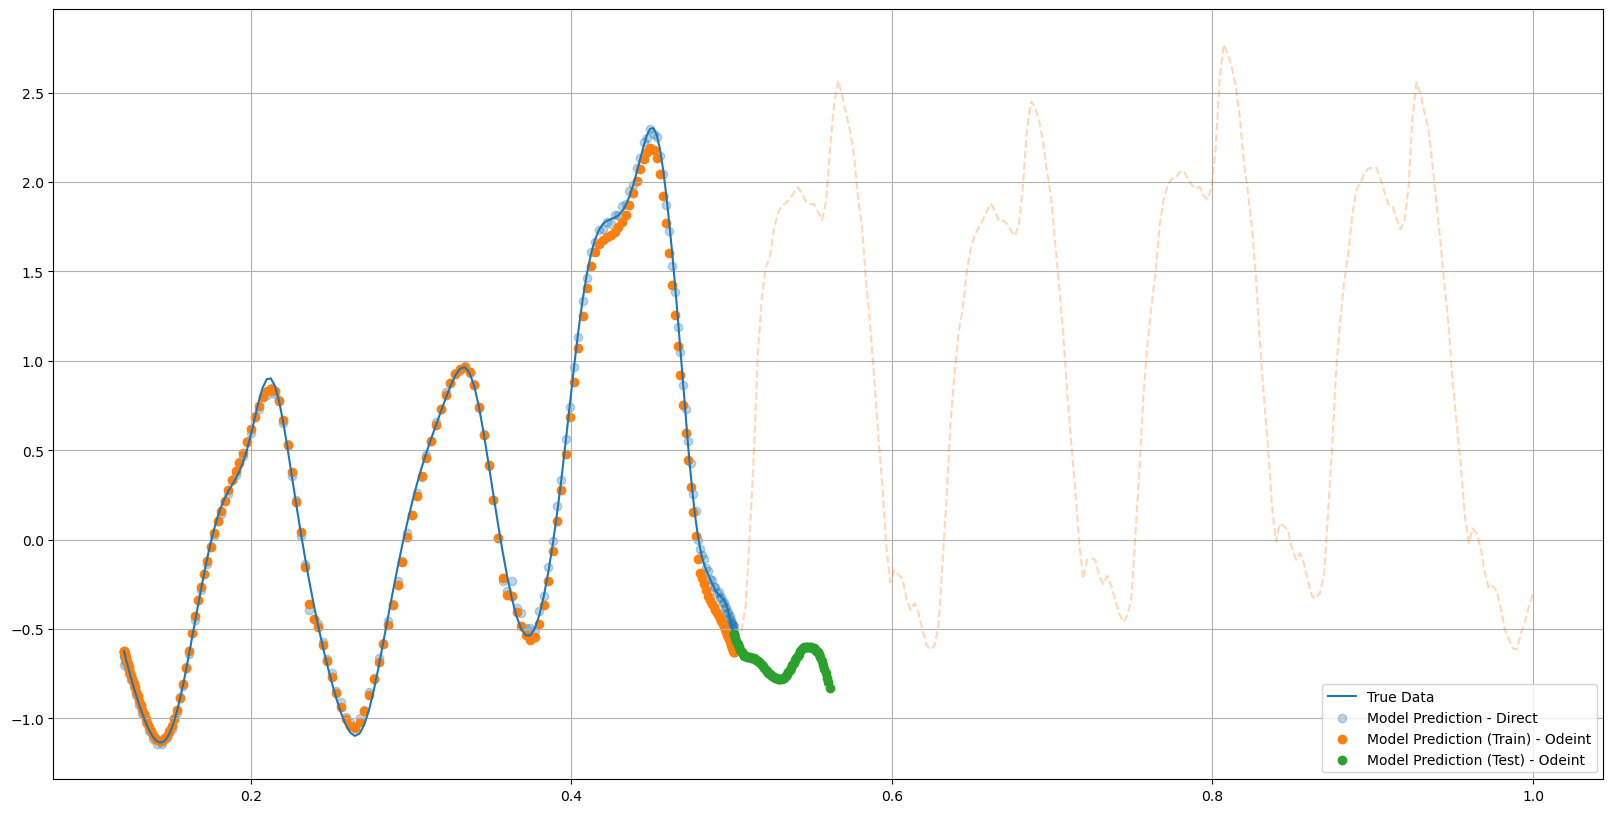

In [76]:
importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

y0 = ys[0]
# step_1 = 150
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

y0_test = y_test_scaled[0]
y_pred_test = ode_model.neural_ode(y0_test, ts_test, (Xs_test, ts_test))

plt.figure(figsize=(20, 10))
# plt.plot(ts, y_train_scaled[offset : train_end], label='True Data', alpha = 0.5)
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(t_test, y_test_scaled, '--', alpha = 0.3)
plt.plot(t_test[0], y_test_scaled[0], 'o', alpha = 1)

# ---------------------------------- EXTRA INPUT ---------------------------------- #
# plt.plot(ts, extra_input, label='Independent Variables', alpha = 0.3, ls = '--')
# plt.plot(t_test, np.array(X_test_scaled), alpha = 0.3, ls = '--')

plt.scatter(ts, u_model, label='Model Prediction - Direct', alpha = 0.3)
plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')
plt.scatter(ts_test, y_pred_test, label='Model Prediction (Test) - Odeint')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

#### Reuse the predictions to continue further

In [455]:
# for the lag2, there is more data available
print(t_test_new[map_lag2].shape)
print(Xs_test.shape)
# we obtained 10 new points from the current prediction
print(y_pred_test.shape)

(25,)
(13, 4)
(13, 1)


In [466]:
# the initial prediction is done only with the data available from the trianing set
y0_test = y_test_scaled[0]
# 13 predictions are made
# the last point will be used as the initial point for the next prediction
# the first 12 points are used to predict the next 12 points
y_pred_test = ode_model.neural_ode(y0_test, ts_test, (Xs_test, ts_test))

y_pred_test_full = y_pred_test
ts_test_full = ts_test

index = 12
offset = 12
x_lag2 = x_lag2_available[index : index + offset]

while index + 13 < len(t_test_new):

    # the initial value needs to be the first time point of the next test set
    Xs_test_next = np.vstack([np.squeeze(y_pred_test[:offset]), np.squeeze(x_lag2[:offset]) , x_test_hour[index : index + offset], x_test_temp[index : index + offset]]).T
    ts_test_next = t_test_new[index : index + offset]
    
    # ensure there is an overlap of the last point
    index += offset
    # conduct the next prediction
    y0_test = y_pred_test[-1]
    x_lag2 = y_pred_test
    y_pred_test = ode_model.neural_ode(y0_test, ts_test_next, (Xs_test_next, ts_test_next))
    
    # append the new prediction to the existing one
    y_pred_test_full = np.append(y_pred_test_full, y_pred_test)
    ts_test_full = np.append(ts_test_full, ts_test_next)
    
    break

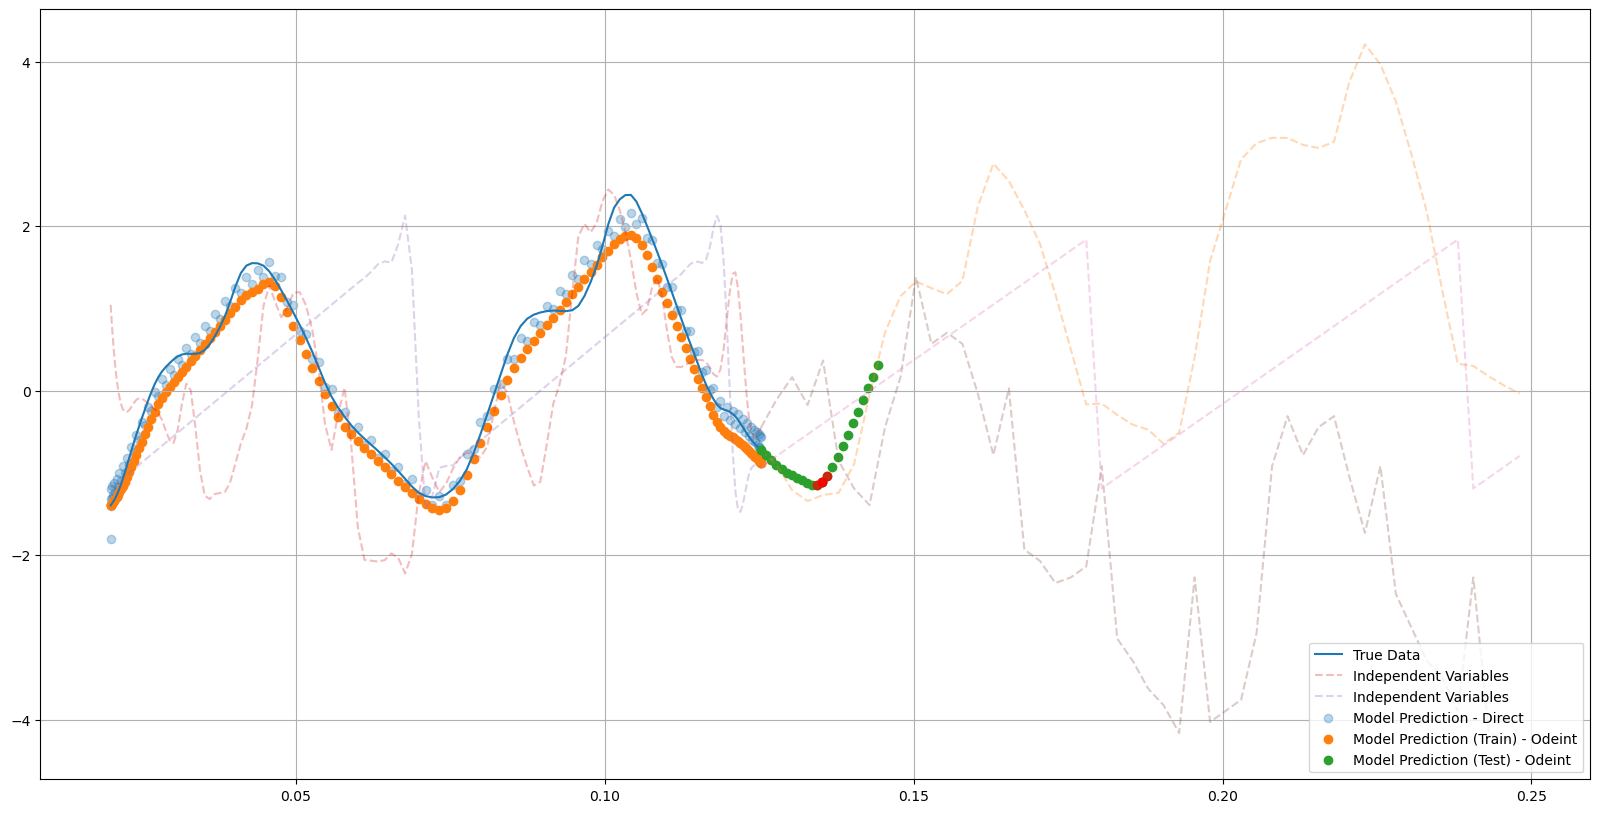

In [475]:
plt.figure(figsize=(20, 10))
# plt.plot(ts, y_train_scaled[offset : train_end], label='True Data', alpha = 0.5)
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(t_test, y_test_scaled, '--', alpha = 0.3)
plt.plot(t_test[0], y_test_scaled[0], 'o', alpha = 1)

# ---------------------------------- EXTRA INPUT ---------------------------------- #
plt.plot(ts, extra_input, label='Independent Variables', alpha = 0.3, ls = '--')
plt.plot(t_test, np.array(X_test_scaled), alpha = 0.3, ls = '--')

plt.scatter(ts, u_model, label='Model Prediction - Direct', alpha = 0.3)
plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')
plt.scatter(ts_test_full, y_pred_test_full, label='Model Prediction (Test) - Odeint')
plt.plot(ts_test_full[11], y_pred_test_full[11], 'o', color = 'red', alpha = 0.7)
plt.plot(ts_test_full[12], y_pred_test_full[12], 'o', color = 'red', alpha = 0.7)
plt.plot(ts_test_full[13], y_pred_test_full[13], 'o', color = 'red', alpha = 0.7)
plt.plot(ts_test_full[14], y_pred_test_full[14], 'o', color = 'red', alpha = 0.7)
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

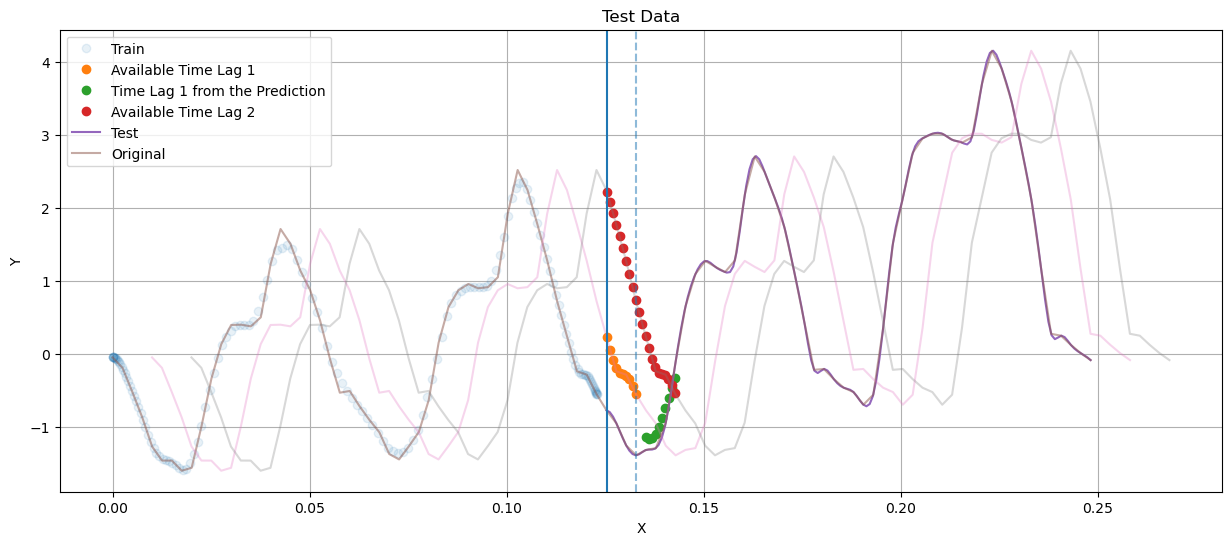

In [416]:
plt.figure(figsize=(15, 6))
plt.plot(x_train_cheb, y_train_cheb, 'o', label='Train', alpha=0.1)
#plt.plot(x_train_cheb + 0.01, y_train_cheb, 'x', label='Train', alpha=0.3)
#plt.plot(x_train_cheb + 0.02, y_train_cheb, 'x', label='Train', alpha=0.3)
plt.plot(t_test_new[map_lag1], x_lag1_available, 'o', label = "Available Time Lag 1")
plt.plot(ts_test + 0.01, y_pred_test, 'o', label = "Time Lag 1 from the Prediction")
plt.plot(t_test_new[map_lag2], x_lag2_available, 'o', label = "Available Time Lag 2")
#plt.plot(x_train_cheb_lags, Xs[:,:2], 'b-', label='Dependent Variables', alpha=0.4, ls = '--')
plt.plot(t_test_new, y_test_scaled_new, '-', label='Test', alpha=1)

plt.plot(t[:100], y_scaled[:100], label = "Original", alpha = 0.5)
plt.plot(t[:100] + 0.01, y_scaled[:100], alpha = 0.3)
plt.plot(t[:100] + 0.02, y_scaled[:100], alpha = 0.3)

plt.axvline(x = t_test_new[0])
plt.axvline(x = (x_train_cheb + 0.01)[-1], ls = '--', alpha = 0.5)
#plt.axvline(x = (x_train_cheb + 0.02)[-1], ls = '--', alpha = 0.25)

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Test Data')
plt.grid(True)
plt.show()

y


Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.1180307865142822, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


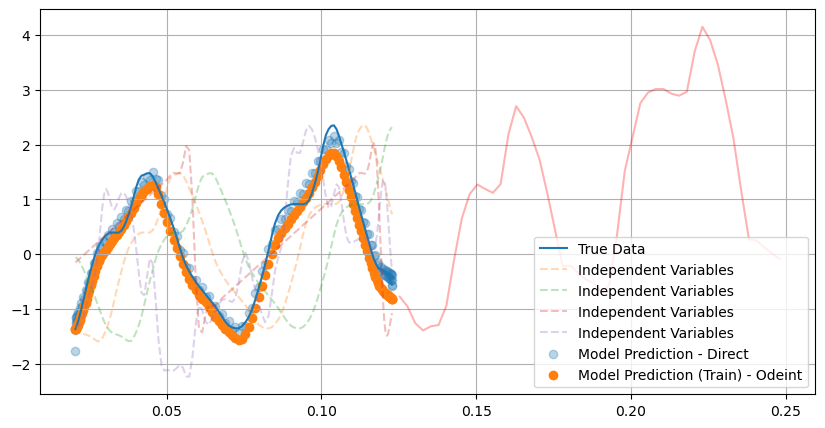

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.9901142120361328, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


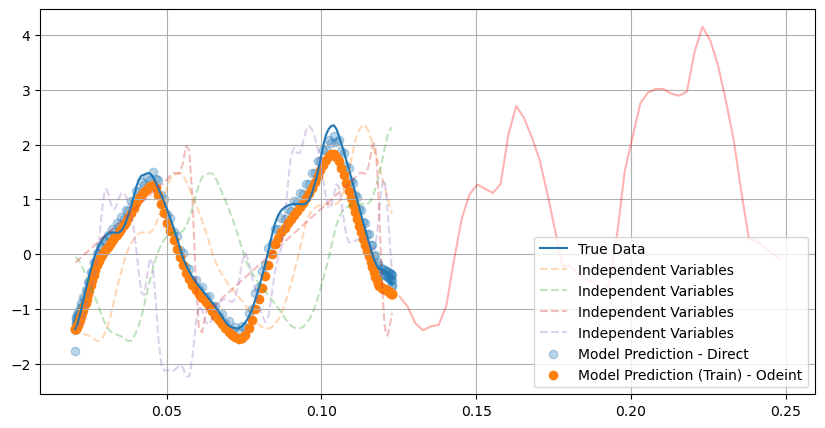

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.1618008613586426, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


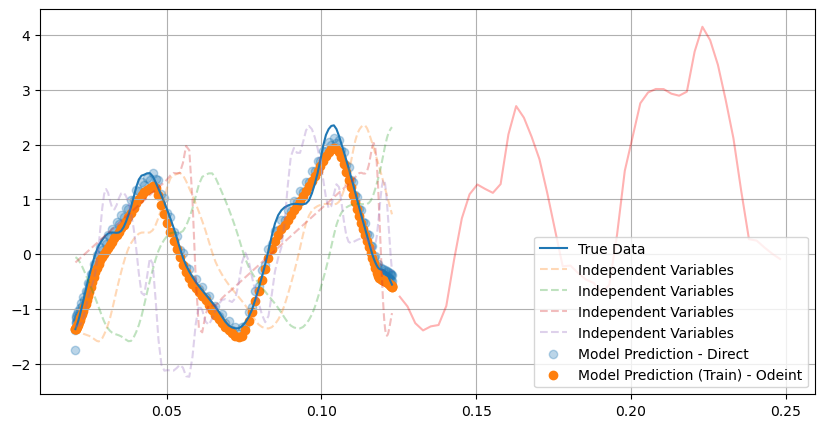

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.9603779315948486, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


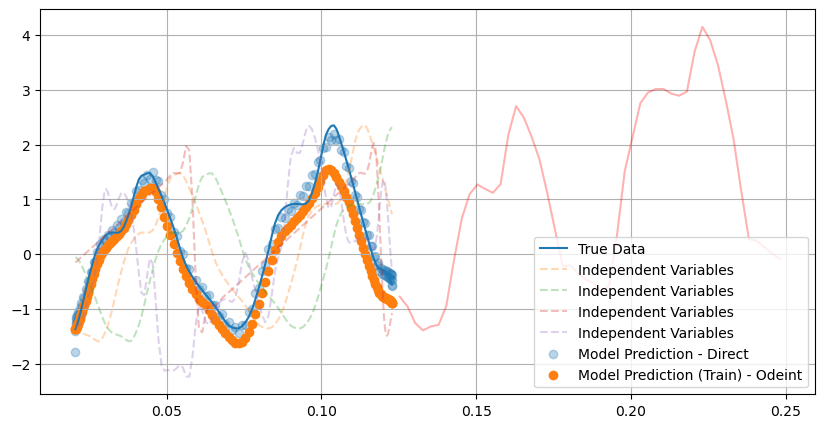

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.2767059803009033, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


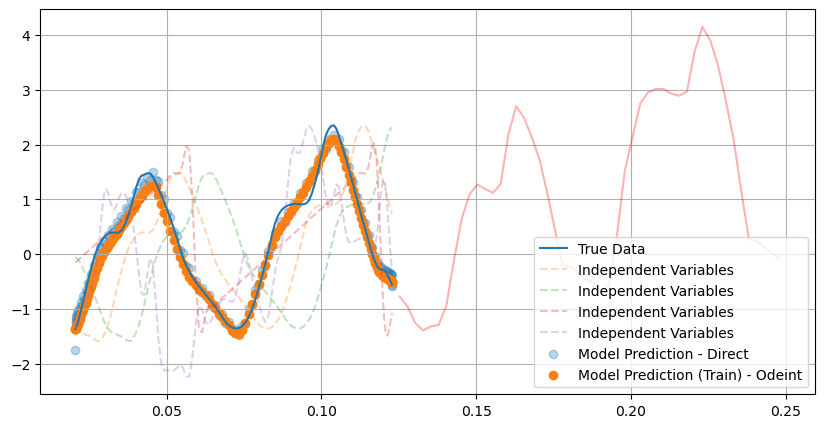

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.2023210525512695, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


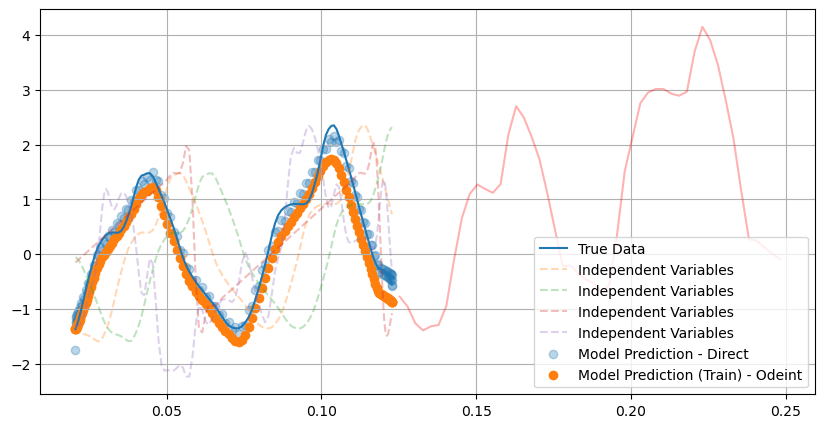

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.022855281829834, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


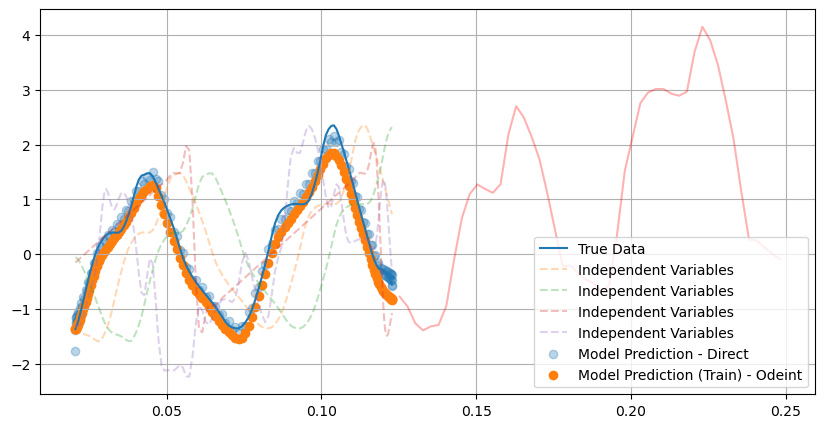

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.8700261116027832, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


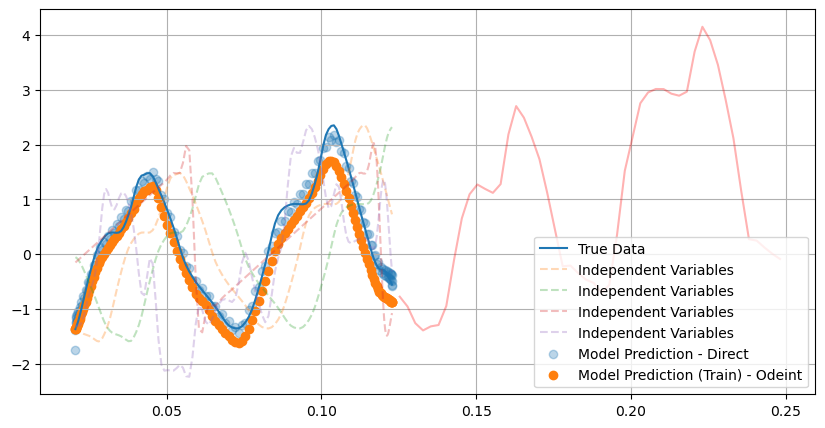

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.7568588256835938, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


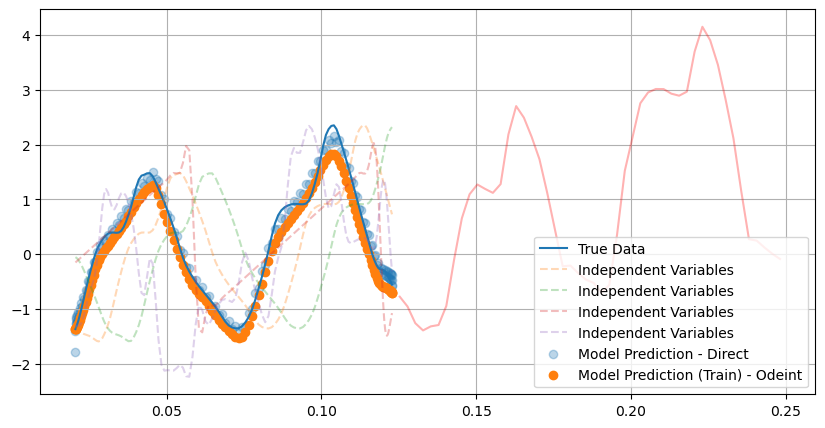

In [149]:
for i in range(1, 10):
        layer_widths = [5, 30, 1]

        # solver.options['print_level'] = 5
        tol = 1e-10
        params = {"tol":1e-10, 
                "dual_inf_tol": tol, 
                "compl_inf_tol": tol,
                "constr_viol_tol": tol, 
                
                # repeat the same for the acceptable tolerances
                # "acceptable_tol": 1e-15,
                # "acceptable_constr_viol_tol": 1e-15,
                # "acceptable_dual_inf_tol": 1e-15,
                # "acceptable_compl_inf_tol": 1e-15,
                "acceptable_iter": 0, 
                
                "halt_on_ampl_error" : 'yes',
                "print_level": 2, 
                #"hessian_approximation": 'limited-memory', 
                #"mu_strategy": 'adaptive', 
                #"check_derivatives_for_naninf": 'yes',
                "max_iter": 1000}

        start_timer_build = time.time()
        ode_model = NeuralODEPyomo(np.array(ys), # y
                                np.array(ts), # t
                                np.array(Ds),
                                
                                layer_widths, act_func = "tanh", 
                                y_init = ys, 
                                penalty_lambda_reg = 0.001, 
                                penalty_lambda_input = 0.0000,
                                # constraint_penalty = 1e-5,  
                                time_invariant = True,
                                extra_input = extra_input, # X
                                w_init_method = 'xavier', 
                                params = params
                                # constraint="l1"
                                )

        ode_model.build_model()
        end_timer_build = time.time()

        result = ode_model.solve_model()
        u_model = ode_model.extract_solution().T

        y0 = ys[0]
        step_1 = 149
        step_2 = 150
        y_pred1 = ode_model.neural_ode(y0, ts[:step_1], (extra_input[:step_1], ts[:step_1]))
        y1 = ys[step_1]
        y_pred2 = ode_model.neural_ode(y1, ts[step_1:step_2], (extra_input[step_1:step_2], ts[step_1:step_2]))

        # test
        y_init_test = y_pred[-1]
        extra_args = np.array(X_test_scaled)

        plt.figure(figsize=(10, 5))
        #plt.plot(ts, y_train_scaled[offset : train_end], label='True Data', alpha = 0.5)
        plt.plot(ts, ys, label='True Data', alpha = 1)
        plt.plot(t_test, y_test_scaled, 'r', alpha = 0.3)
        plt.plot(ts, extra_input, label='Independent Variables', alpha = 0.3, ls = '--')
        # plt.plot(t_test, np.array(X_test_scaled), alpha = 0.3, ls = '--')

        plt.scatter(ts, u_model, label='Model Prediction - Direct', alpha = 0.3)
        plt.scatter(ts[:step_1], y_pred1, label='Model Prediction (Train) - Odeint')
        plt.scatter(ts[step_1:step_2], y_pred2)
        #plt.scatter(t_test, y_pred_test, label='Model Prediction (Train) - Odeint')
        plt.legend(loc ="lower right")
        plt.grid(True)
        plt.show()

---

----

In [150]:
from data_generation import generate_ode_data

#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp = np.array(jnp.squeeze(y_noisy_vdp))
t_vdp = np.array(jnp.squeeze(t_vdp))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t_vdp)
D_vdp = np.array(lagrange_derivative(t_vdp, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_vdp, estimated_solution_vdp = collocate_data(y_noisy_vdp, t_vdp, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [29]:
import neural_net_pyomo_2

importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

layer_widths = [2, 10, 2]

# solver.options['print_level'] = 5
tol = 1e-5
params = {"tol":1e-7, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          #"acceptable_tol": 1e-15,
          #"acceptable_dual_inf_tol": 1e-15,
          #"acceptable_constr_viol_tol": 1e-15,
          #"acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 3000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(y_vdp), # y
                           np.array(t_vdp), # t
                           np.array(D_vdp),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = np.array(estimated_solution_vdp), 
                           penalty_lambda_reg = 0.001, 
                           penalty_lambda_input = 0.00,
                           # constraint_penalty = 1e-5,  
                           
                           # extra_input = extra_input, # X
                           w_init_method = 'xavier', 
                           params = params,
                           constraint="l1"
                           )

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution()

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/03_eda_energy_consumtion/neural_net_pyomo_2.py:74: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_tol=1e-05
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    96316
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    20641

Total number of variables............................:      452
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      452


In [30]:
from jax.experimental.ode import odeint
 
y0 = jnp.array([0.0, 1.0])
y_pred_train = ode_model.neural_ode(y0, t_vdp)  
mae_train = jnp.mean(jnp.abs(y_pred_train - y_vdp))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = ode_model.neural_ode(y1, t_test_vdp[N-1:]) 
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test_vdp[N-1:]))
print (f"Test MAE: {mae_test}")

Train MAE: 0.11943044941570297
Test MAE: 0.49445077743189725


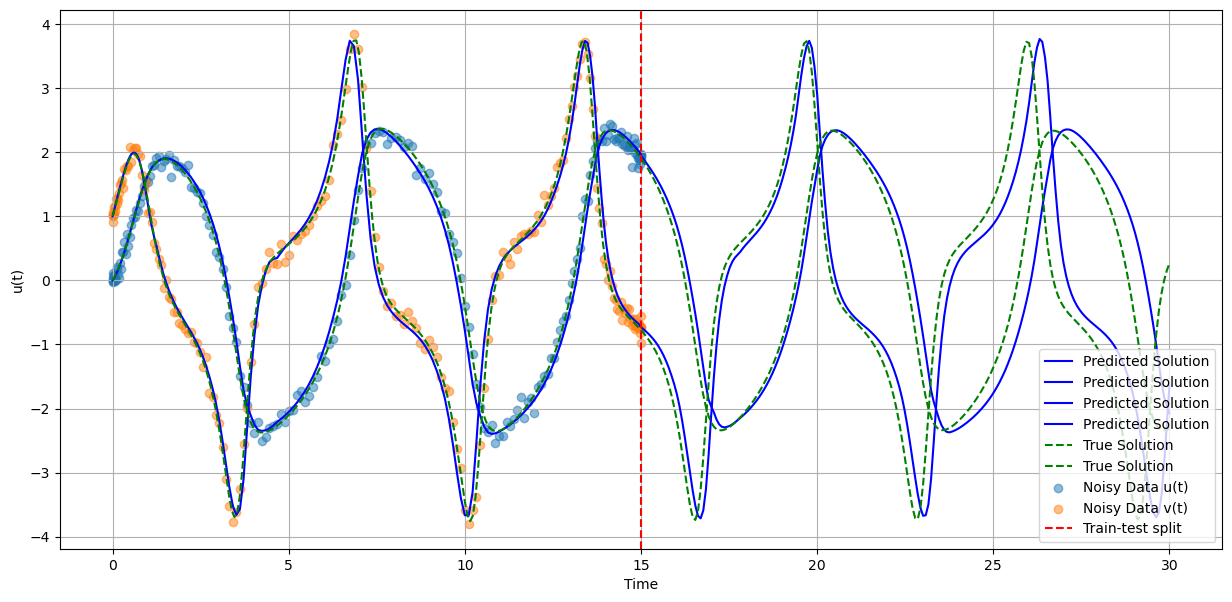

In [31]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
# plt.plot(t_vdp, np.array(u_model).T, 'b', label='Predicted Solution')
plt.plot(t_vdp, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test_vdp[N-1:], y_pred_test, 'b', label='Predicted Solution')

plt.plot(t_test_vdp, y_test_vdp, 'g--', label='True Solution')

plt.scatter(t_vdp, y_noisy_vdp.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_vdp, y_noisy_vdp.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [164]:
t_new = x_train_cheb[offset : split]
t_new.shape
X_train_scaled[offset : split].shape

(97, 2)

In [167]:
X_train_scaled[offset : split]

temperature      hour
3      0.959727 -1.277286
4      0.791652 -1.253379
5      0.642722 -1.222682
6      0.544745 -1.185226
7      0.516285 -1.141050
..          ...       ...
95    -1.732811 -0.970897
96    -1.751552 -0.938147
97    -1.763682 -0.914371
98    -1.769392 -0.900562
99    -1.770926 -0.896096

[97 rows x 2 columns]

In [ ]:
def neural_ode(self, params, y0, t, state, extra_args=None): 
    results = []    
       
    def func(y, t, args):
        input = jnp.atleast_1d(y)
        
        if not self.time_invariant:
            input = jnp.append(input, t)
            
        if args is not None:
            extra_inputs, t_all = args
            
            if isinstance(extra_inputs, (np.ndarray, jnp.ndarray)):
                # after confirming that extra inputs is an array
                # there are 2 further options to consider:
                # multiple datapoints and multiple features
                
                if extra_inputs.ndim == 2:
                    # we have multiple datapoints
                    index = jnp.argmin(jnp.abs(t_all - t))
                    for extra_input in extra_inputs[index]:
                            input = jnp.append(input, extra_input)
                            
                elif extra_inputs.ndim == 1:
                    # we have a single datapoint so no need to slice the index
                    for extra_input in extra_inputs:
                            input = jnp.append(input, extra_input)
                    
            else: # if a single value, simply append it
                input = jnp.append(input, extra_inputs)
        
        result = state.apply_fn({'params': params}, input) 
             
        return result
        
    return odeint(func, y0, t, extra_args)

In [166]:
def func(y, t, args):
    input = jnp.atleast_1d(y)
    
    if not self.time_invariant:
        input = jnp.append(input, t)
        
    if args is not None:
        extra_inputs, t_all = args
        
        if isinstance(extra_inputs, (np.ndarray, jnp.ndarray)):
            # after confirming that extra inputs is an array
            # there are 2 further options to consider:
            # multiple datapoints and multiple features
            
            if extra_inputs.ndim == 2:
                # we have multiple datapoints
                index = jnp.argmin(jnp.abs(t_all - t))
                for extra_input in extra_inputs[index]:
                        input = jnp.append(input, extra_input)
                        
            elif extra_inputs.ndim == 1:
                # we have a single datapoint so no need to slice the index
                for extra_input in extra_inputs:
                        input = jnp.append(input, extra_input)
                
        else: # if a single value, simply append it
            input = jnp.append(input, extra_inputs)
    
    result = state.apply_fn({'params': params}, input) 
            
    return result
    
def system_dynamics(t, y, embeddings, t_new):
    # -1 to account for the zero indexing
    current_index = np.searchsorted(t_new, t, side='right') - 1
    
    input = np.array([y[0]])
    
    # for each embedding:
    for i in range(m):
        input = np.append(input, embeddings[current_index][i])
        
    # input = np.array([y[0]])
    du_dt = ode_model.predict(input) 
    return du_dt

initial_conditions = np.array(y_train_scaled[offset])
t_span = (t_new[0], t_new[-1])
sol = solve_ivp(system_dynamics, t_span, initial_conditions, t_eval=t_new, args=(X_train_scaled[offset : split], t_new))

y_pred_train = sol.y
t_points = sol.t

ode_solution = np.squeeze(y_pred_train.T)

KeyError: 0

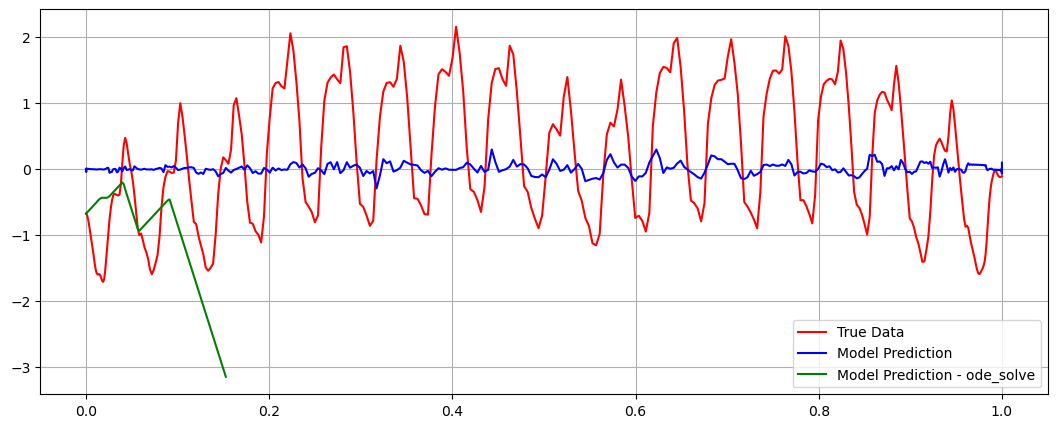

In [126]:
plt.figure(figsize=(13, 5))
plt.plot(t_train[offset : split], y_train_scaled[offset : split], 'r', label='True Data')
plt.plot(t_train[offset : split], u_model, 'b', label='Model Prediction')
plt.plot(t_train[offset : split][:100], ode_solution[:100], 'g', label='Model Prediction - ode_solve')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()